## WRITEUP WILL FOLLOW SHORTLY

(Currently there's code for the regression that follows the example in the paper)

<div style="width: 200px;">![Graphical Model](images/graphicalModel_LinearRegression.png)</div>

In this first example

In [1]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
# This chunk of code defines some variables (variable names), and a function to read in the data.

num_iterations = 1000

# data location
dataset_path = os.path.join(os.path.abspath('..'), "CognitionData", "data_wheelOnly.csv")

OUTCOME_VAR_NAMES = ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
EMOTION_VAR_NAMES = ["happy", "sad", "anger", "surprise", "disgust", "fear", "content", "disapp"]
OUTCOME_VAR_DIM = len(OUTCOME_VAR_NAMES)
EMOTION_VAR_DIM = len(EMOTION_VAR_NAMES)

def load_outcome_emotion_dataset(csv_file, normalize_values=True):
    data_readin = pd.read_csv(csv_file)
    outcome_data = data_readin.loc[:,OUTCOME_VAR_NAMES]
    if normalize_values:
        ####
        ## payoff1, payoff2, payoff3 and win are between 0 and 100
        ## need to normalize to [0,1] to match the rest of the variables,
        ## by dividing payoff1, payoff2, payoff3 and win by 100
        ####
        outcome_data.loc[:,"payoff1"] = outcome_data.loc[:,"payoff1"]/100
        outcome_data.loc[:,"payoff2"] = outcome_data.loc[:,"payoff2"]/100
        outcome_data.loc[:,"payoff3"] = outcome_data.loc[:,"payoff3"]/100
        outcome_data.loc[:,"win"]     = outcome_data.loc[:,"win"]/100
    outcome_data = torch.tensor(outcome_data.values).type(torch.Tensor)
    
    # the actual data has 8 emotions, but for illustration we just use 1 emotion, happy
    # the rest of the functions below assume a 1-D "y" variable
    #emotion_data = data_readin.loc[:,EMOTION_VAR_NAMES]
    emotion_data = data_readin.loc[:, "happy"]
    if normalize_values:
        ## note that emotions are transformed from a 9 point Likert to [0,1] via emo <- (emo-1)/8
        emotion_data   = (emotion_data-1)/8
    emotion_data = emotion_data.values.reshape( emotion_data.shape[0] , 1)
    emotion_data = torch.tensor(emotion_data).type(torch.Tensor)
    
    data = torch.cat((outcome_data, emotion_data), 1)
    return data


# reads in datafile
outcome_emotion_dataset = load_outcome_emotion_dataset(csv_file=dataset_path)
N_samples = outcome_emotion_dataset.shape[0]

In [3]:
def compute_appraisal(outcome_data):
    # We have a simple hard-coded these appraisals, for illustration
    # This is following Ong, Zaki, & Goodman (2015)
    # the outcome data columns are, in order:
    # ["payoff1", "payoff2", "payoff3", "prob1", "prob2", "prob3", "win", "winProb", "angleProp"]
    # the 3 appraisal variables are: 
    #     amount won ("win"),
    #     Prediction Error PE = win - EV, where EV = prob1*payoff1 + prob2*payoff2 + prob3*payoff3
    #     absolute value of PE
    
    # if outcome_data only has 1 observation, reshape so vectorization works
    if(len(outcome_data.shape)==1):
        outcome_data = outcome_data.view(1,9)
        print(outcome_data.shape)
    
    # initializing appraisalVals
    appraisalVals = torch.zeros(size=(outcome_data.shape[0],3))
    appraisalVals[:,0] = outcome_data[:,6] # amount won
    
    # Expected value
    EV = outcome_data[:,0] * outcome_data[:,3] + \
         outcome_data[:,1] * outcome_data[:,4] + \
         outcome_data[:,2] * outcome_data[:,5]
    
    # prediction error and absolute PE
    appraisalVals[:,1] = appraisalVals[:,0] - EV
    appraisalVals[:,2] = abs(appraisalVals[:,1])
    return(appraisalVals)


In [4]:
def fit_regression_model(data):
    # define the hyperparameters that control the gaussian prior over the regression coeffs.
    # mean = 0, scale = 1
    coeff_mean_prior = torch.tensor(0.0)
    coeff_scale_prior = torch.tensor(1.0)
    
    # sample b_0 (intercept) and b_1 to b_3 (regression coeffs)
    b_0 = pyro.sample("b_0", Normal(coeff_mean_prior, coeff_scale_prior))
    b_1 = pyro.sample("b_1", Normal(coeff_mean_prior, coeff_scale_prior))
    b_2 = pyro.sample("b_2", Normal(coeff_mean_prior, coeff_scale_prior))
    b_3 = pyro.sample("b_3", Normal(coeff_mean_prior, coeff_scale_prior))
    
    # loop over observed data
    with pyro.iarange("map", data.shape[0]):
        outcome_data = data[:, :-1]
        emotion_data = data[:, -1]
        appraisal_vars = compute_appraisal(outcome_data)
        
        # run the regression forward
        prediction = b_0 + b_1 * appraisal_vars[:,0] + b_2 * appraisal_vars[:,1] + b_3 * appraisal_vars[:,2]
        # condition on the observed data
        pyro.sample("obs", Normal(prediction, 1), obs = emotion_data)

In [5]:
def fit_regression_guide(data):
    coeff_mean_b0  = pyro.param("coeff_mean_b0",  torch.tensor(0.0))
    coeff_scale_b0 = pyro.param("coeff_scale_b0", torch.tensor(1.0))
    coeff_mean_b1  = pyro.param("coeff_mean_b1",  torch.tensor(0.0))
    coeff_scale_b1 = pyro.param("coeff_scale_b1", torch.tensor(1.0))
    coeff_mean_b2  = pyro.param("coeff_mean_b2",  torch.tensor(0.0))
    coeff_scale_b2 = pyro.param("coeff_scale_b2", torch.tensor(1.0))
    coeff_mean_b3  = pyro.param("coeff_mean_b3",  torch.tensor(0.0))
    coeff_scale_b3 = pyro.param("coeff_scale_b3", torch.tensor(1.0))
    # sample coefficients from Normal(mean, scale)
    pyro.sample("b_0", Normal(coeff_mean_b0, coeff_scale_b0))
    pyro.sample("b_1", Normal(coeff_mean_b1, coeff_scale_b1))
    pyro.sample("b_2", Normal(coeff_mean_b2, coeff_scale_b2))
    pyro.sample("b_3", Normal(coeff_mean_b3, coeff_scale_b3))

[iteration 0001] loss: 2.8718
[iteration 0101] loss: 1.0747
[iteration 0201] loss: 0.9652
[iteration 0301] loss: 1.0088
[iteration 0401] loss: 0.9450
[iteration 0501] loss: 0.9437
[iteration 0601] loss: 0.9620
[iteration 0701] loss: 0.9496
[iteration 0801] loss: 0.9420
[iteration 0901] loss: 0.9435


Text(0,0.5,'loss')

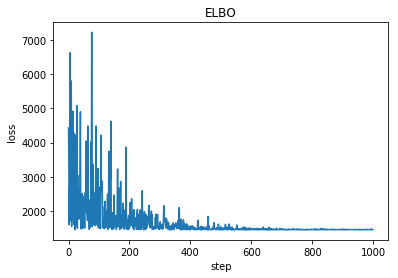

In [6]:
pyro.clear_param_store()

# setup the optimizer
optimizer = Adam({"lr": 0.005})

# setup the inference algorithm
svi = SVI(fit_regression_model, fit_regression_guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(num_iterations):
    # calculate the loss and take a gradient step
    thisLoss = svi.step(outcome_emotion_dataset)
    losses.append(thisLoss)
    if step % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (step + 1, thisLoss / float(N_samples)))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")


In [7]:
# output the learned variational parameters
learnt_params = [pyro.param("coeff_mean_b0").item(), pyro.param("coeff_scale_b0").item(),
                 pyro.param("coeff_mean_b1").item(), pyro.param("coeff_scale_b1").item(),
                 pyro.param("coeff_mean_b2").item(), pyro.param("coeff_scale_b2").item(),
                 pyro.param("coeff_mean_b3").item(), pyro.param("coeff_scale_b3").item()]
print(learnt_params)

[0.33048996329307556, 0.028995094820857048, 0.4694053530693054, 0.047070346772670746, 0.6430254578590393, 0.10659278184175491, 0.09655304253101349, 0.2090882658958435]
